# Homework Starter — Stage 08 EDA
Sparsh patel 08/20/2025


In [1]:
import os
os.chdir('/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework8')
print(os.getcwd())

/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework8


## Creation of synthetic data

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)


n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


In [3]:
pip install --upgrade seaborn matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
df.to_csv('/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework8/data/stage8.csv', index=False)

Saved the df to a CSV file

## 1) First look
Gives the basic information on the 
- Info
- General stats
- Null values

In [5]:
df.info(), df.isna().sum(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int64         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.6+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64,
                       date         age        income  transactions       spend
 count                  160  160.000000    155.000000     160.00000  157.000000
 mean   2021-04-21 12:00:00   40.018750  41983.866323       3.23750  117.291592
 min    2021-02-01 00:00:00   22.000000  17928.800000       0.00000    0.540000
 25%    2021-03-12 18:00:00   34.700000  32471.530000       2.00000   77.250000
 50%    2021-04-21 12:00:00   40.150000  39332.520000       3.00000  119.320000
 75%    2021-05-31 06:00:00   44.925000  49697.690000       4.00000  153.340000
 max    2021-07-10 00:00:00   61.100000  87052.400000      20.00000  280.050000
 std                    NaN    8.458676  13262.457038       2.58561   51.768645)

## 2) Numeric profile

In [6]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


#### 1. Age
- Skew = 0.07 → Almost perfectly symmetric (very close to 0).
- Kurtosis = -0.08 → Near 0, suggesting distribution is close to normal.
- Insight: Age is roughly normally distributed (bell-shaped). No strong skew or heavy tails.

#### 2. Income
- Skew = 0.99 → Moderately positively skewed (long tail on the right). Higher incomes are pulling the distribution.
- Kurtosis = 0.92 → Slightly leptokurtic (heavier tails than normal). Suggests occasional extreme high incomes.
- Insight: Income has a long right tail → most people earn around 32–49k, but a few high earners (~87k) stretch the distribution.

#### 3. Transactions
- Skew = 3.47 → Heavily positively skewed (long right tail). Many customers have low transactions (0–4), but some go as high as 20.
- Kurtosis = 19.98 → Extremely leptokurtic → huge spikes around low values, plus extreme outliers.
- Insight: Transactions are very uneven. Most people transact a few times, but a tiny group transact much more frequently (outliers).

#### 4. Spend
- Skew = 0.13 → Very close to 0 → nearly symmetric distribution.
- Kurtosis = -0.08 → Near 0 → approximately normal (not too peaked or flat).
- Insight: Spending is normally distributed around ~119, with few extremes.

## 3) Univariate Distributions 
### Histogram 

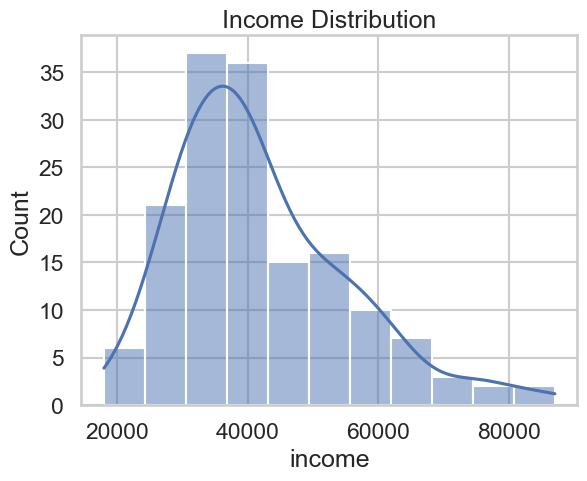

In [15]:

sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()


#### Results from Income analysis
- It is a right tailed distribution
- Most people earn around 32–49k, but a few high earners (~87k) stretch the distribution

### Boxplot

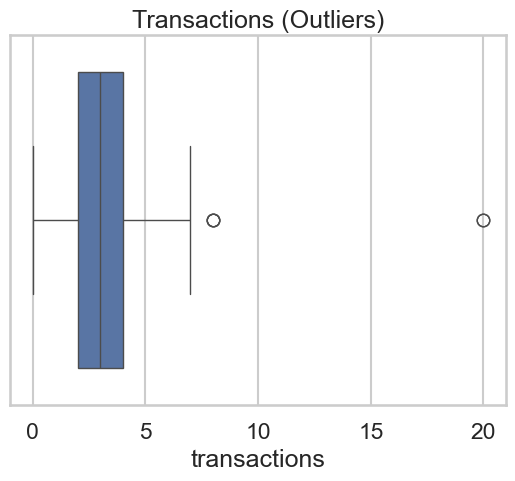

,date,region,age,income,transactions,spend
14,2021-02-15,South,36,39386.15,7,174.84
21,2021-02-22,South,43,61985.58,6,184.23
24,2021-02-25,East,40,35085.29,7,237.35
39,2021-03-12,South,37,45999.27,6,185.90
40,2021-03-13,East,40,30060.89,6,207.91
46,2021-03-19,East,26,41899.63,6,144.08
51,2021-03-24,West,50,50463.34,20,167.16
52,2021-03-25,West,36,57676.63,8,280.05
83,2021-04-25,East,36,37914.97,8,190.66
87,2021-04-29,West,40,39891.87,6,160.34


In [16]:
sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

df.loc[df['transactions'] > 5, ]   

#### Results from Transaction analysis
- All transactions are around 3, with higher being 7
- Transactions 8 and 20 are considered outliers as they do not fit the normal transaction numbers

### Countplot

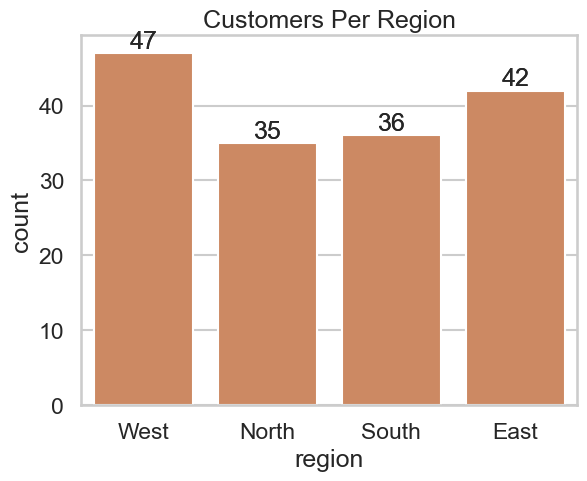

In [9]:
(sns.countplot(x='region', data=df))
ax = sns.countplot(x='region', data=df)
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f") 
plt.title('Customers Per Region')

plt.show()

We can see the difference between the customers in each region

## 4) Relationships 

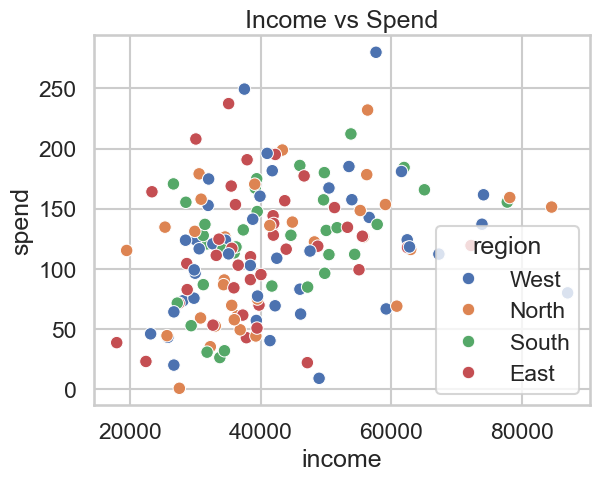

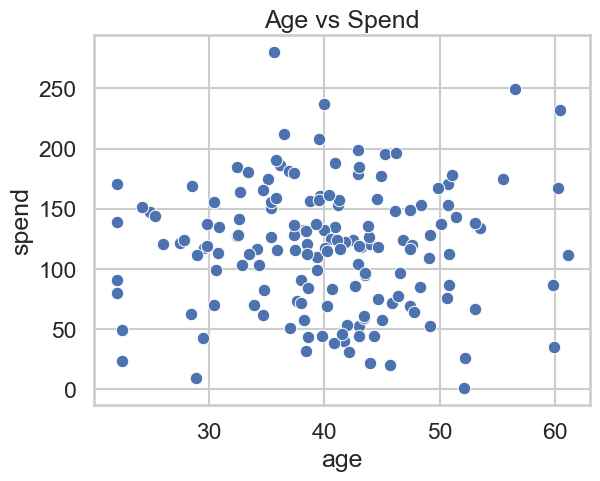

In [10]:
sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend')
plt.show()

sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

- We see a generalised overview and spending of each of the income vs spend and age vs spend

### Scatterplots by region

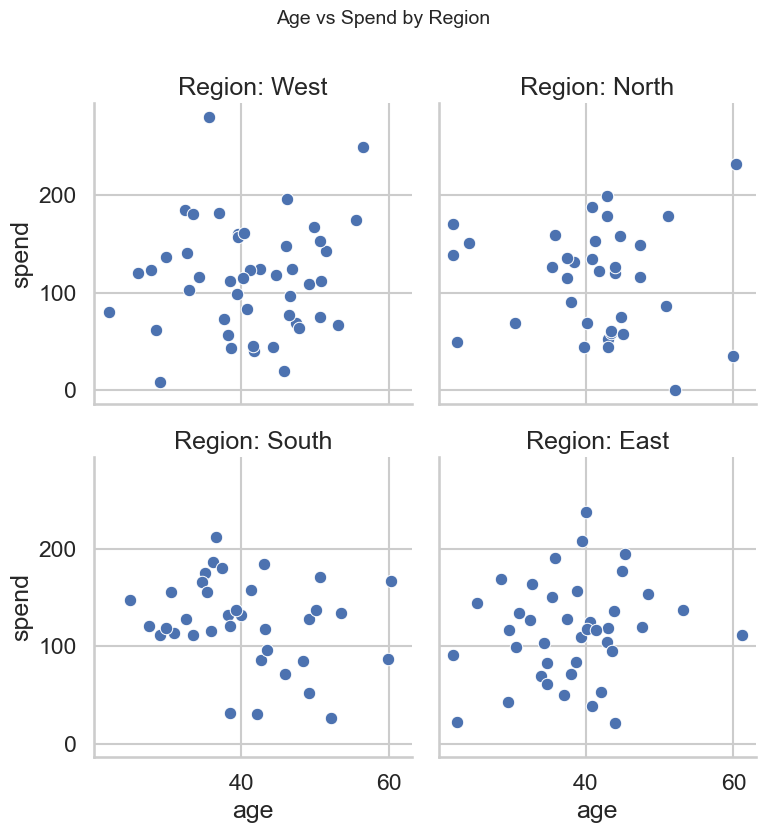

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot: one plot per region
g = sns.relplot(
    data=df,
    x="age",
    y="spend",
    col="region",       
    kind="scatter",
    col_wrap=2,         
    height=4,           
    aspect=1
)

g.set_titles("Region: {col_name}") 
plt.suptitle("Age vs Spend by Region", y=1.05, fontsize=14)  
plt.show()


### West
- Spending is fairly scattered, with some very high spenders above 200.
- No clear linear relationship between age and spend, though middle-aged customers (35–50) seem to have more - concentrated spending.
### North
- Spending is clustered around 100–150, with fewer extreme outliers.
- Younger customers (<35) and older ones (>50) appear more volatile in spend (some very low, some very high).
- Slight trend: mid-age customers (35–45) spend more consistently.
### South
- More balanced spread of spending across ages.
- Ages 35–45 show higher concentration of spending between 120–180.
- Younger and older groups tend to show more variability.
### East
- Very wide variation in spend regardless of age.
- Several high spenders around 200+, but spread is more uniform.
- No strong correlation between age and spend—customers of all ages seem to have similar likelihood of being high or low spenders.

<Axes: xlabel='region', ylabel='spend'>

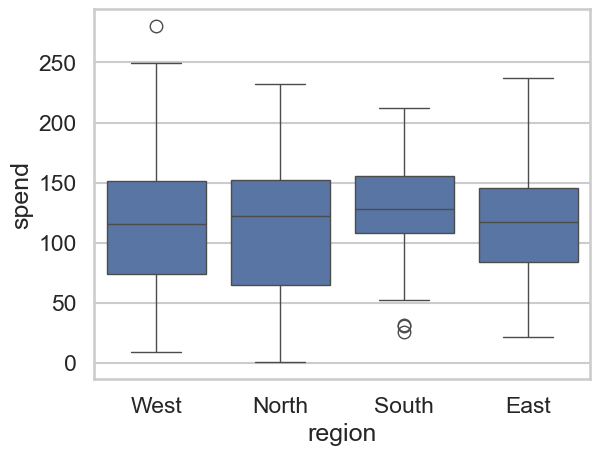

In [12]:
(sns.boxplot(x='region', y='spend', data=df))

- We see that North and East have a normally distributed spending
- West region seems to have an outlier who spends mre than the normal 
- South region has two outliers which spend less than normal

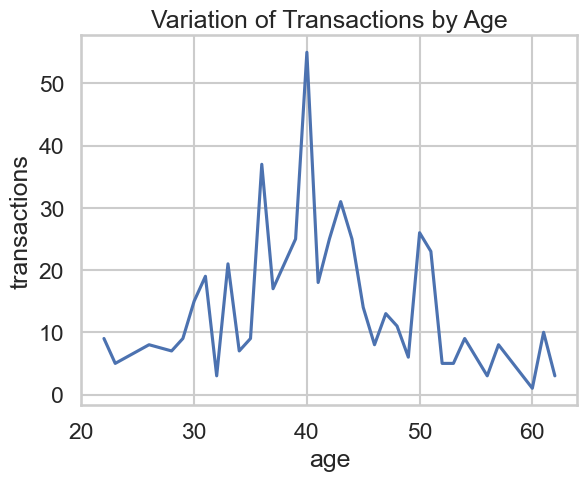

In [13]:
df['age'] = np.ceil(df['age']).astype(int) 
sns.lineplot(df.groupby('age')['transactions'].sum()) 
plt.title('Variation of Transactions by Age')
plt.show()

### Here we first rounded up the ages to get a better view of their spending habbits.
- People aged around 40 tend to do the most transaction. 
- This maybe due to the fact that they might have a lot of bills to pay, eg. Rent, Utilities, Family and Children

## 5)  Correlation matrix

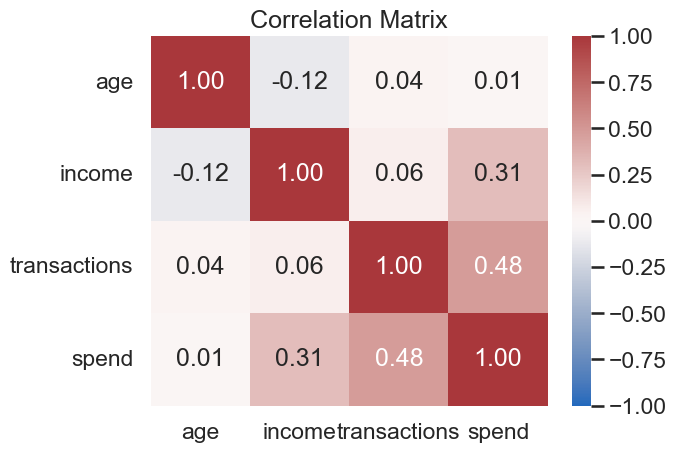

,age,income,transactions,spend
age,1.000000,-0.119436,0.038290,0.010133
income,-0.119436,1.000000,0.063573,0.307307
transactions,0.038290,0.063573,1.000000,0.480685
spend,0.010133,0.307307,0.480685,1.000000


In [14]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

### We can see that 
- Number of transactions and Spending has decent correlation, which is to be expected
- Something shocking we see is that Income does not seem to be positively correlated with age. So Income decreases as people grow older.

## 6) Insights & Assumptions (write your commentary)
### I have mentioned all the insights with each of the respective plots so it is easier to understand.

### Assumptions & Risks
- Assumption: The sample data is representative of the broader population in each region.
- Risk: If the dataset is skewed (e.g., missing certain income or demographic segments), the observed weak correlation might understate or overstate the real trend.
- Assumption: Spending behavior is primarily captured by age and region.
- Risk: Ignoring other drivers (e.g., income, lifestyle, promotions, loyalty programs) could lead to misleading interpretations.
## Next Steps Before Modeling (Already done in previous notebooks)
- Data Cleaning:
Handle missing values (consider median imputation for numerical stability).
- Winsorize or remove extreme outliers that may distort regression coefficients.
Feature Engineering:
Create an outlier flag to test model robustness with and without extreme spenders.
Encode categorical variables (e.g., region) properly for modeling.
- Exploratory Checks:
Run preliminary regression with and without outliers to compare impact on coefficients and model fit.
